In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Packages

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
import scikitplot

# Load Dataframe

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/EMOCNN/fer2013.csv')

train_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
train_df.shape

(35887, 3)

# Label Distribution

In [ ]:
(train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index().T

,0,1,2,3,4,5,6
emotion,0.138017,0.015242,0.142698,0.250481,0.169337,0.111517,0.172709


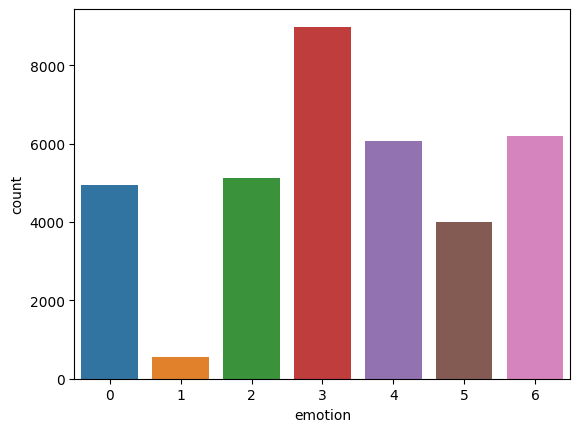

In [ ]:
sns.countplot(x='emotion',data=train_df)
plt.show()

# View Sample of Images

In [ ]:
emotion_label = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

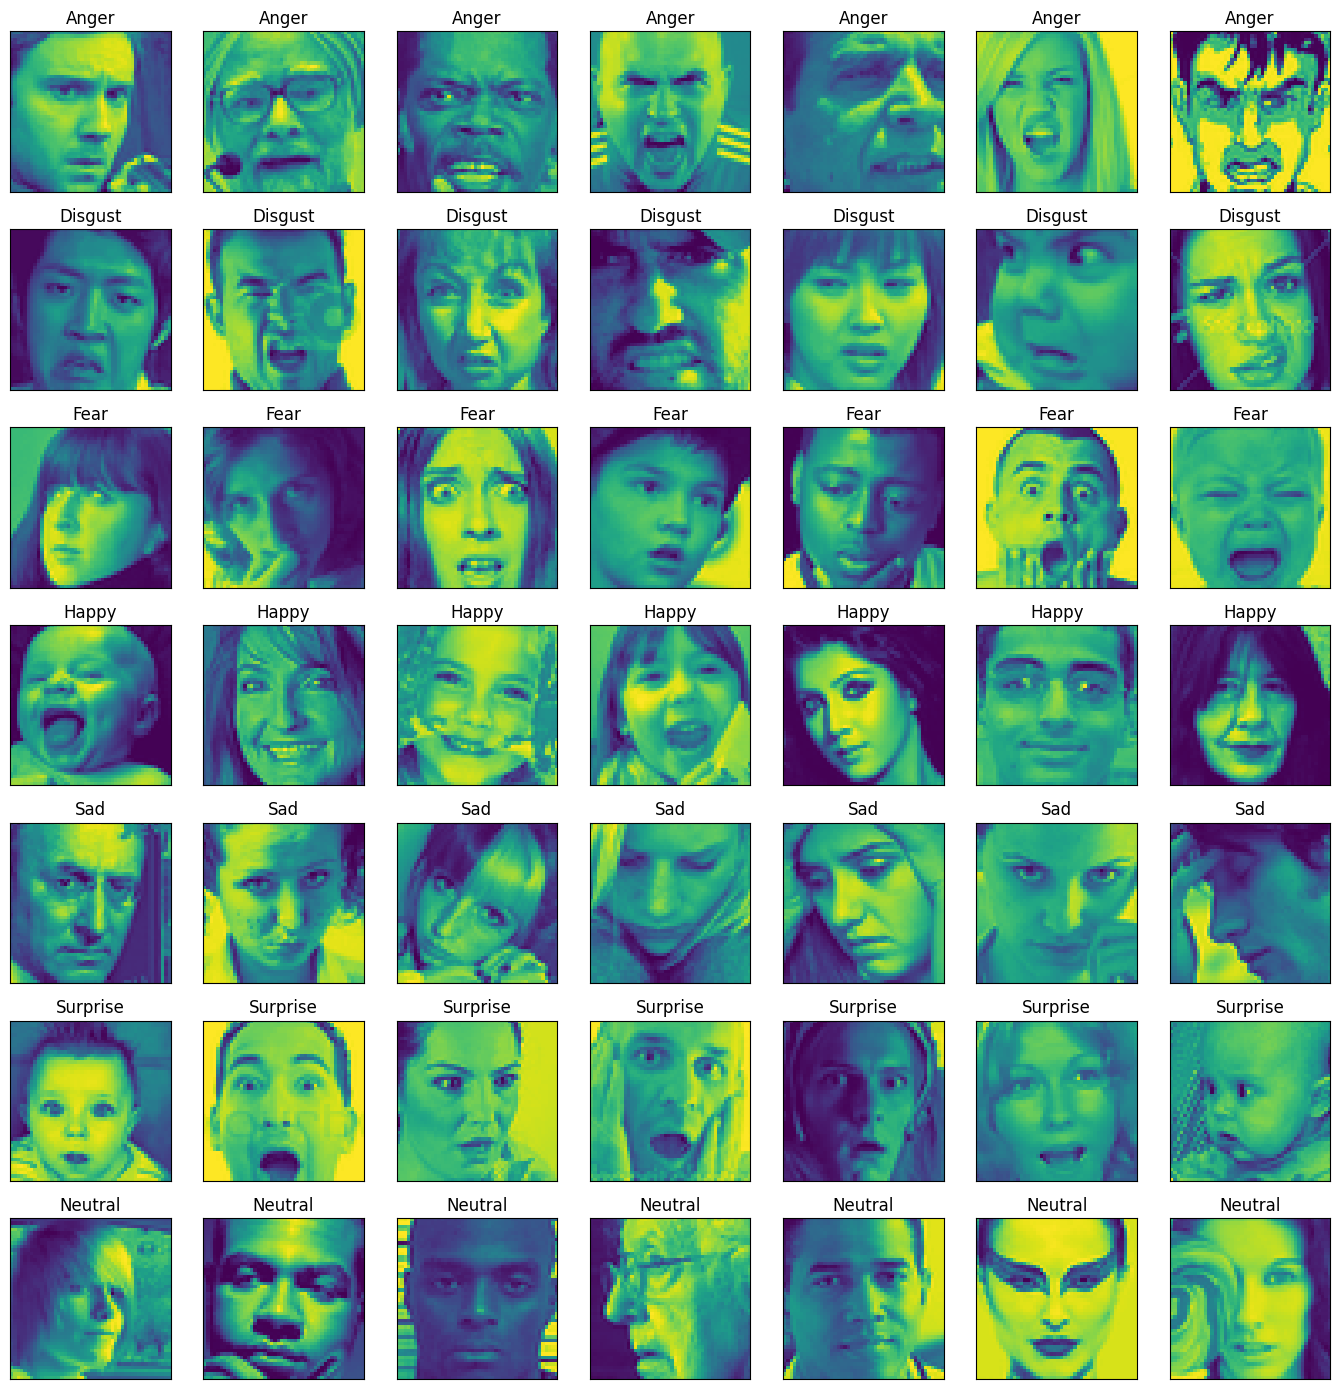

In [ ]:
fig = plt.figure(1, (14,14))
k=0

for label in sorted(train_df.emotion.unique()):
    for j in range(7):
        px = train_df[train_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

# Data Generators

In [ ]:
train_df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train_df['pixels']]
img_array = np.concatenate(train_df.pixels)

le = LabelEncoder()
#One-hit-encoded labels
img_labels = le.fit_transform(train_df.emotion)
img_labels = np_utils.to_categorical(img_labels)

In [ ]:
print('Pixel Shape: ', img_array.shape)
print('Label Shape: ', img_labels.shape)

Pixel Shape:  (35887, 48, 48, 1)
Label Shape:  (35887, 7)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=1)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(28709, 48, 48, 1) (7178, 48, 48, 1) (28709, 7) (7178, 7)


In [ ]:
Xs_train = X_train / 255
Xs_valid = X_valid / 255

In [ ]:
#Used for Model
X_train_color = np.repeat(Xs_train, repeats=3, axis=3)
X_valid_color = np.repeat(Xs_valid, repeats=3, axis=3)
print(X_train_color.shape)
print(X_valid_color.shape)

(28709, 48, 48, 3)
(7178, 48, 48, 3)


# Build Network

In [ ]:
base_model = tf.keras.applications.VGG19(input_shape=(48,48,3),
                                    include_top=False,
                                    weights='imagenet')

#Start with a non trainable model
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
cnn = Sequential ([
    base_model,
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(7, activation='softmax')
])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               2

# Train Network

In [ ]:
opt = tf.keras.optimizers.Adam(0.001)

cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


## Training Run 1

In [ ]:
%%time

h1 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=500,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/500
448/448 [==============================] - 1156s 3s/step - loss: 1.9543 - accuracy: 0.2399 - val_loss: 1.6718 - val_accuracy: 0.3245
Epoch 2/500
448/448 [==============================] - 1188s 3s/step - loss: 1.7087 - accuracy: 0.3189 - val_loss: 1.6366 - val_accuracy: 0.3502
Epoch 3/500
448/448 [==============================] - 1186s 3s/step - loss: 1.6657 - accuracy: 0.3390 - val_loss: 1.6155 - val_accuracy: 0.3622
Epoch 4/500
448/448 [==============================] - 1188s 3s/step - loss: 1.6402 - accuracy: 0.3509 - val_loss: 1.5960 - val_accuracy: 0.3617
Epoch 5/500
448/448 [==============================] - 1184s 3s/step - loss: 1.6264 - accuracy: 0.3577 - val_loss: 1.5962 - val_accuracy: 0.3608
Epoch 6/500
448/448 [==============================] - 1154s 3s/step - loss: 1.6115 - accuracy: 0.3663 - val_loss: 1.5729 - val_accuracy: 0.3745
Epoch 7/500
448/448 [==============================] - 1170s 3s/step - loss: 1.5994 - accuracy: 0.3703 - val_loss: 1.5741 - val_ac

In [ ]:
history = h1.history
print(history.keys())

In [ ]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
cnn.save('/content/drive/MyDrive/EMOCNN/vgg19.h5')
pickle.dump(history, open(f'/content/drive/MyDrive/EMOCNN/vgg19.pkl', 'wb'))

## Training Run 2

In [ ]:
tf.keras.backend.set_value(cnn.optimizer.learning_rate, 0.0001)

In [ ]:
%%time

h2 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=50,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

2022-11-13 22:29:37.646743: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634991616 exceeds 10% of free system memory.
2022-11-13 22:29:38.353767: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634991616 exceeds 10% of free system memory.


Epoch 1/50
358/358 [==============================] - 7s 19ms/step - loss: 1.3448 - accuracy: 0.4830 - val_loss: 1.5162 - val_accuracy: 0.4148
Epoch 2/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3376 - accuracy: 0.4875 - val_loss: 1.5187 - val_accuracy: 0.4162
Epoch 3/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3279 - accuracy: 0.4925 - val_loss: 1.5190 - val_accuracy: 0.4169
Epoch 4/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3246 - accuracy: 0.4947 - val_loss: 1.5172 - val_accuracy: 0.4185
Epoch 5/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3236 - accuracy: 0.4962 - val_loss: 1.5171 - val_accuracy: 0.4181
Epoch 6/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3167 - accuracy: 0.4964 - val_loss: 1.5168 - val_accuracy: 0.4173
Epoch 7/50
358/358 [==============================] - 6s 18ms/step - loss: 1.3180 - accuracy: 0.4958 - val_loss: 1.5227 - val_accuracy: 0.4190

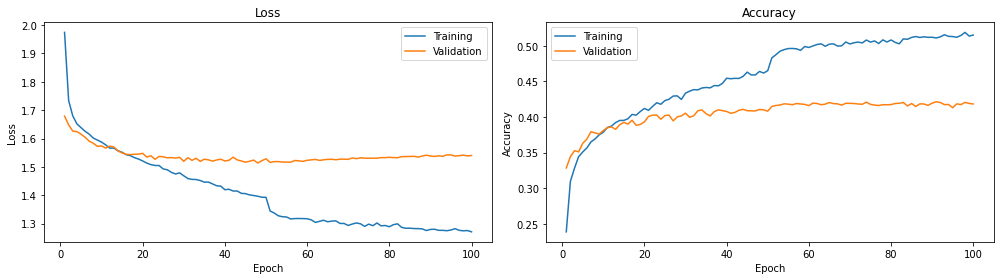

In [ ]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Traing Run 3

In [ ]:
base_model.trainable = True

opt = tf.keras.optimizers.Adam(0.00001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time

h3 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=50,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

2022-11-13 22:35:04.493427: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634991616 exceeds 10% of free system memory.


Epoch 1/50
358/358 [==============================] - 19s 47ms/step - loss: 1.4507 - accuracy: 0.4539 - val_loss: 1.4516 - val_accuracy: 0.4491
Epoch 2/50
358/358 [==============================] - 16s 45ms/step - loss: 1.3282 - accuracy: 0.4979 - val_loss: 1.4016 - val_accuracy: 0.4688
Epoch 3/50
358/358 [==============================] - 16s 45ms/step - loss: 1.2548 - accuracy: 0.5226 - val_loss: 1.3228 - val_accuracy: 0.4969
Epoch 4/50
358/358 [==============================] - 16s 45ms/step - loss: 1.2032 - accuracy: 0.5450 - val_loss: 1.2807 - val_accuracy: 0.5066
Epoch 5/50
358/358 [==============================] - 16s 45ms/step - loss: 1.1546 - accuracy: 0.5677 - val_loss: 1.2875 - val_accuracy: 0.5031
Epoch 6/50
358/358 [==============================] - 16s 45ms/step - loss: 1.1119 - accuracy: 0.5881 - val_loss: 1.2529 - val_accuracy: 0.5223
Epoch 7/50
358/358 [==============================] - 16s 44ms/step - loss: 1.0651 - accuracy: 0.6057 - val_loss: 1.2258 - val_accuracy:

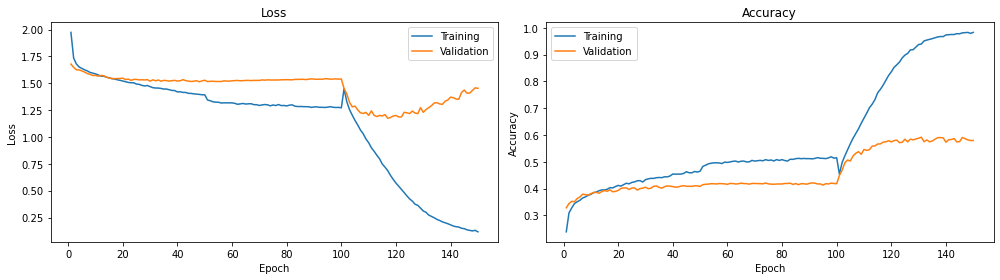

In [ ]:
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

## Training Run 4

In [ ]:
opt = tf.keras.optimizers.Adam(0.000001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time

h4 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=50,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/50
358/358 [==============================] - 18s 46ms/step - loss: 0.0977 - accuracy: 0.9889 - val_loss: 1.3893 - val_accuracy: 0.5927
Epoch 2/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0881 - accuracy: 0.9916 - val_loss: 1.3848 - val_accuracy: 0.5932
Epoch 3/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0887 - accuracy: 0.9921 - val_loss: 1.3839 - val_accuracy: 0.5967
Epoch 4/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0838 - accuracy: 0.9922 - val_loss: 1.3732 - val_accuracy: 0.5953
Epoch 5/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0839 - accuracy: 0.9927 - val_loss: 1.3900 - val_accuracy: 0.5946
Epoch 6/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0819 - accuracy: 0.9925 - val_loss: 1.3756 - val_accuracy: 0.5968
Epoch 7/50
358/358 [==============================] - 16s 45ms/step - loss: 0.0793 - accuracy: 0.9941 - val_loss: 1.3813 - val_accuracy:

# Save Model

In [ ]:
cnn.save('FER_Transfer_Learning_v02.h5')
pickle.dump(history, open(f'FER_Transfer_Learning_v02.pkl', 'wb'))